In [2]:
from IPython.display import HTML

HTML("""
<div style="text-align: center; background: #2d3748; color: #e2e8f0; padding: 40px; border-radius: 8px;">
    <h1 style="color: #cbd5e0; margin-bottom: 30px; font-size: 2.5em;">Machine translation</h1>
    
    <div style="max-width: 700px; margin: 0 auto; font-size: 16px; line-height: 1.6;">
        <p style="margin-bottom: 20px;">Machine translation (MT) is the study of how to use computers to translate from one language into another. In terms of methodologies MT mainly falls in two categories: rule-based methods and corpus-based-methods.</p>
        
        <p style="margin-bottom: 10px;">In this short notebook a dataset containing japanese and english text will be loaded and prepared for a machine translation task.</p>
        
    </div>
</div>
""")

# Import 

In [3]:
import kagglehub
from pathlib import Path
import pandas as pd
import xml.etree.ElementTree as ET
from pprint import pprint
from collections import Counter
from sklearn.model_selection import train_test_split 
import tqdm as notebook_tqdm
import matplotlib.pyplot as plt

import utils

import logging
logging.getLogger("transformers.modeling_utils").setLevel(logging.ERROR)

from IPython.display import HTML


c:\Users\laran\Home\Documents\code\venv\NLPvenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
html = """
<!DOCTYPE html>
<html lang="en">
<div style="font-family: Arial, sans-serif; line-height:1.6;">

  <!-- Title -->
  <h2 style="text-align:center; color:#222;">Machine Translation (MT) Techniques</h2>

  <!-- Root -->
  <div style="border:2px solid #444; border-radius:10px; padding:15px; width:90%; margin:auto; background-color:#f9f9f9;">

    <h3 style="text-align:center; margin:5px 0; color:#333;">MT Methodologies</h3>

    <!-- Categories -->
    <div style="display:flex; justify-content:space-around; margin-top:20px;">

      <!-- Rule-based -->
      <div style="flex:1; margin:10px; padding:10px; border:1px solid #999; border-radius:8px; background-color:#d9ecff;">
        <h4 style="text-align:center; color:#004080;">Rule-Based MT (RBMT)</h4>
        <p style="font-size:14px;">
          • Uses bilingual dictionaries<br>
          • Relies on manually written linguistic rules<br>
          • Less flexible, resource-intensive
        </p>
      </div>

      <!-- Corpus-based -->
      <div style="flex:2; margin:10px; padding:10px; border:1px solid #999; border-radius:8px; background-color:#eafbe7;">
        <h4 style="text-align:center; color:#006600;">Corpus-Based MT</h4>

        <div style="margin-left:10px;">

          <h5 style="color:#227700;">1. Example-Based (EBMT)</h5>
          <p style="font-size:14px; margin-left:15px;">
            • Translates by retrieving similar sentences from bilingual corpus<br>
            • Originated with Nagao (1984)
          </p>

          <h5 style="color:#996600;">2. Statistical (SMT)</h5>
          <p style="font-size:14px; margin-left:15px;">
            • Learns translation knowledge automatically from large bilingual data<br>
            • Phrase-based, word-based, hierarchical approaches
          </p>

          <h5 style="color:#cc3300;">3. Neural (NMT)</h5>
          <p style="font-size:14px; margin-left:15px;">
            • Uses deep learning for sequence-to-sequence translation<br>
            • Components: <b>Encoder</b> (semantic representation) and <b>Decoder</b> (generates target)<br>
            • Architectures: RNNs (LSTM/GRU), currently Transformer-based<br>
            • No manually encoded rules
          </p>

        </div>
      </div>
    </div>
  </div>
</div>
</html>
"""

from IPython.display import HTML
HTML(html)


# Data

In [5]:
# Download latest version
root=Path(kagglehub.dataset_download("team-ai/japaneseenglish-bilingual-corpus"))
print(root)


C:\Users\laran\.cache\kagglehub\datasets\team-ai\japaneseenglish-bilingual-corpus\versions\3


Source of the data: https://www.kaggle.com/datasets/team-ai/japaneseenglish-bilingual-corpus

In [6]:
files=sorted(p for p in root.rglob("*") if p.is_file())
pprint(files[:10])

[WindowsPath('C:/Users/laran/.cache/kagglehub/datasets/team-ai/japaneseenglish-bilingual-corpus/versions/3/BDS00389.xml'),
 WindowsPath('C:/Users/laran/.cache/kagglehub/datasets/team-ai/japaneseenglish-bilingual-corpus/versions/3/fonts-japanese-gothic.ttf'),
 WindowsPath('C:/Users/laran/.cache/kagglehub/datasets/team-ai/japaneseenglish-bilingual-corpus/versions/3/kyoto_lexicon.csv'),
 WindowsPath('C:/Users/laran/.cache/kagglehub/datasets/team-ai/japaneseenglish-bilingual-corpus/versions/3/readme.pdf'),
 WindowsPath('C:/Users/laran/.cache/kagglehub/datasets/team-ai/japaneseenglish-bilingual-corpus/versions/3/wiki_corpus_2.01/BDS/BDS00001.xml'),
 WindowsPath('C:/Users/laran/.cache/kagglehub/datasets/team-ai/japaneseenglish-bilingual-corpus/versions/3/wiki_corpus_2.01/BDS/BDS00002.xml'),
 WindowsPath('C:/Users/laran/.cache/kagglehub/datasets/team-ai/japaneseenglish-bilingual-corpus/versions/3/wiki_corpus_2.01/BDS/BDS00003.xml'),
 WindowsPath('C:/Users/laran/.cache/kagglehub/datasets/team-

Files are mostly XML files, to be able to use the parallel english / japanese text the XML files must be parsed first: 

### 1) check the tags

In [7]:
base = root / "wiki_corpus_2.01" / "BDS"
xml_file = sorted(base.glob("BDS*.xml"))[0]
root = ET.parse(xml_file).getroot()

for el in root.iter():
    print(el.tag, el.attrib)
    # Stop early to avoid printing everything
    if len(list(el)) > 0:
        break


art {'orl': 'ja', 'trl': 'en'}


Tags are 'ja' for japanese and 'en' for english.  
The structure will be further explored to properly extract japanese - english pairs

### 2. inspect the structure

In [8]:
assert root.tag.endswith("art") and root.attrib.get("orl")=="ja" and root.attrib.get("trl")=="en"

# List first-level children under <art>
lvl1 = [c.tag for c in root]

print("Level-1 child tags:", Counter(lvl1))

# Peek deeper: for each distinct lvl1 tag, show its distinct children and sample text
def strip_ns(tag): 
    return tag.split("}",1)[1] if "}" in tag else tag

seen = set()
for c in root:
    t = strip_ns(c.tag)
    if t in seen: 
        continue
    seen.add(t)
    sub = [strip_ns(x.tag) for x in list(c)]
    print(f"\n<{t}> children:", Counter(sub))
    # print a couple of leaf texts
    for leaf in c.iter():
        if len(list(leaf))==0 and (leaf.text or "").strip():
            txt = leaf.text.strip().replace("\n"," ")[:120]
            print(f"  sample leaf <{strip_ns(leaf.tag)}>: {txt}")
            break


Level-1 child tags: Counter({'sec': 6, 'par': 5, 'inf': 1, 'tit': 1, 'copyright': 1})

<inf> children: Counter()
  sample leaf <inf>: jawiki-20080607-pages-articles.xml

<tit> children: Counter({'e': 3, 'cmt': 3, 'j': 1})
  sample leaf <j>: 雪舟

<par> children: Counter({'sen': 2})
  sample leaf <j>: 雪舟（せっしゅう、1420年（応永27年） - 1506年（永正3年））は号で、15世紀後半室町時代に活躍した水墨画家・禅僧で、画聖とも称えられる。

<sec> children: Counter({'par': 3, 'tit': 1})
  sample leaf <j>: 生涯

<copyright> children: Counter()
  sample leaf <copyright>: copyright (c) 2010 Avanzare(id:34657), Kanejan(id:78613), Tommy6(id:51773), Nnh(id:474), Suguri F(id:11127), FREEZA(id:6


**interpretation**: 
- Root is: <art orl="ja" trl="en">
- frequent childrens are: sec, par, tit, inf, copyright
- language tags are: < j > for japanese and < e > for english 


With these informations we can built the extractor. 

### 3) Built the extractor and the paired dataframe

In [9]:
# base = root / "wiki_corpus_2.01" / "BDS"
base.glob("BDS*.xml")

TAG_PAIR      = None         # No wrapper available
TAG_ORIGINAL  = "j"          # japanese tag
TAG_TRANSL    = "e"          # english tag

def strip_ns(tag):
    return tag.split("}",1)[1] if "}" in tag else tag

def text_or_none(el):
    return (el.text or "").strip() if el is not None and el.text else None

pairs = []
for xf in sorted(base.glob("BDS*.xml")):
    root = ET.parse(xf).getroot()

    if TAG_PAIR:
        # option 1 --> if I have the wrapper (not our case as TAG_PAIR=None)
        for node in root.findall(f".//{TAG_PAIR}"):
            ja = text_or_none(node.find(TAG_ORIGINAL))
            en = text_or_none(node.find(TAG_TRANSL))
            if ja and en:
                pairs.append((ja, en))
    else:
        # option 2 --> called in case we have no explicit wrapper (our case)
        for node in root.iter():
            children = list(node)
            if not children: 
                continue
            tagmap = {strip_ns(c.tag).lower(): c for c in children}
            if TAG_ORIGINAL.lower() in tagmap and TAG_TRANSL.lower() in tagmap:
                ja = text_or_none(tagmap[TAG_ORIGINAL.lower()])
                en = text_or_none(tagmap[TAG_TRANSL.lower()])
                if ja and en:
                    pairs.append((ja, en))

df = pd.DataFrame(pairs, columns=["ja", "en"]).dropna()   # dataframe and cleaning


In [10]:
HTML("""
<style>
.xml-container {
    max-width: 1000px;
    margin: 20px auto;
    padding: 30px;
    background: linear-gradient(135deg, #f5f7fa 0%, #c3cfe2 100%);
    border-radius: 16px;
    box-shadow: 0 10px 30px rgba(0,0,0,0.1);
    font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
    position: relative;
    overflow: hidden;
}

.xml-container::before {
    content: '';
    position: absolute;
    top: 0;
    left: 0;
    right: 0;
    bottom: 0;
    background: url('data:image/svg+xml,<svg xmlns="http://www.w3.org/2000/svg" viewBox="0 0 100 100"><circle cx="25" cy="25" r="1" fill="rgba(255,255,255,0.3)"/><circle cx="75" cy="75" r="1.5" fill="rgba(255,255,255,0.2)"/><circle cx="50" cy="10" r="0.8" fill="rgba(255,255,255,0.4)"/></svg>') repeat;
    pointer-events: none;
}

.header {
    text-align: center;
    margin-bottom: 25px;
    position: relative;
    z-index: 2;
}

.main-title {
    font-size: 2.2em;
    font-weight: 700;
    margin: 0;
    background: linear-gradient(135deg, #667eea 0%, #764ba2 100%);
    -webkit-background-clip: text;
    -webkit-text-fill-color: transparent;
    background-clip: text;
    text-shadow: 0 2px 4px rgba(0,0,0,0.1);
}

.legend {
    display: flex;
    gap: 15px;
    justify-content: center;
    margin: 20px 0;
    flex-wrap: wrap;
    position: relative;
    z-index: 2;
}

.legend-item {
    background: rgba(255, 255, 255, 0.9);
    backdrop-filter: blur(10px);
    padding: 8px 16px;
    border-radius: 20px;
    font-size: 0.9em;
    font-weight: 500;
    box-shadow: 0 2px 8px rgba(0,0,0,0.1);
    border: 1px solid rgba(255,255,255,0.2);
    transition: all 0.3s ease;
}

.legend-item:hover {
    transform: translateY(-2px);
    box-shadow: 0 4px 12px rgba(0,0,0,0.15);
}

.data-source { background: linear-gradient(135deg, #e3f2fd, #bbdefb); color: #1565c0; }
.xml-nodes { background: linear-gradient(135deg, #f3e5f5, #e1bee7); color: #7b1fa2; }
.traversal { background: linear-gradient(135deg, #e8f5e8, #c8e6c9); color: #2e7d32; }
.output { background: linear-gradient(135deg, #fff8e1, #ffecb3); color: #f57c00; }

.flowchart-container {
    background: rgba(255, 255, 255, 0.95);
    backdrop-filter: blur(15px);
    border-radius: 12px;
    padding: 25px;
    margin: 20px 0;
    box-shadow: 0 8px 25px rgba(0,0,0,0.1);
    border: 1px solid rgba(255,255,255,0.3);
    position: relative;
    z-index: 2;
}

.flowchart-svg {
    width: 100%;
    height: auto;
    max-width: 950px;
    display: block;
    margin: 0 auto;
}

.notes-section {
    background: rgba(255, 255, 255, 0.9);
    backdrop-filter: blur(10px);
    border-radius: 12px;
    padding: 20px;
    margin-top: 20px;
    border-left: 4px solid #667eea;
    position: relative;
    z-index: 2;
}

.notes-title {
    font-size: 1.2em;
    font-weight: 600;
    color: #2c3e50;
    margin: 0 0 15px 0;
}

.notes-list {
    margin: 0;
    padding-left: 20px;
    color: #34495e;
    line-height: 1.6;
}

.notes-list li {
    margin-bottom: 8px;
    position: relative;
}

.notes-list code {
    background: rgba(103, 126, 234, 0.1);
    padding: 2px 6px;
    border-radius: 4px;
    font-family: 'Consolas', 'Monaco', monospace;
    font-size: 0.9em;
    color: #667eea;
}

@media (max-width: 768px) {
    .xml-container {
        margin: 10px;
        padding: 20px;
    }
    
    .main-title {
        font-size: 1.8em;
    }
    
    .legend {
        gap: 10px;
    }
    
    .legend-item {
        padding: 6px 12px;
        font-size: 0.8em;
    }
    
    .flowchart-container {
        padding: 15px;
    }
}
</style>

<div class="xml-container">
    <div class="header">
        <h1 class="main-title">XML Structure & Pair Extraction</h1>
        <p style="color: #7f8c8d; font-size: 1.1em; margin: 5px 0 0 0;">Advanced Schematic Visualization</p>
    </div>

    <div class="legend">
        <div class="legend-item data-source">📁 Data Source</div>
        <div class="legend-item xml-nodes">🏷️ XML Nodes</div>
        <div class="legend-item traversal">🔄 Traversal Logic</div>
        <div class="legend-item output">📋 Output</div>
    </div>

    <div class="flowchart-container">
        <svg class="flowchart-svg" viewBox="0 0 950 550" role="img" aria-label="Enhanced flowchart of XML parsing and bilingual pair extraction">
            <defs>
                <marker id="arrow" viewBox="0 0 12 12" refX="10" refY="6" markerWidth="10" markerHeight="10" orient="auto-start-reverse">
                    <path d="M 2 2 L 10 6 L 2 10 z" fill="#4a5568" stroke="#4a5568" stroke-width="1"/>
                </marker>
                
                <linearGradient id="dataGradient" x1="0%" y1="0%" x2="100%" y2="100%">
                    <stop offset="0%" style="stop-color:#e3f2fd;stop-opacity:1" />
                    <stop offset="100%" style="stop-color:#bbdefb;stop-opacity:1" />
                </linearGradient>
                
                <linearGradient id="xmlGradient" x1="0%" y1="0%" x2="100%" y2="100%">
                    <stop offset="0%" style="stop-color:#f3e5f5;stop-opacity:1" />
                    <stop offset="100%" style="stop-color:#e1bee7;stop-opacity:1" />
                </linearGradient>
                
                <linearGradient id="traversalGradient" x1="0%" y1="0%" x2="100%" y2="100%">
                    <stop offset="0%" style="stop-color:#e8f5e8;stop-opacity:1" />
                    <stop offset="100%" style="stop-color:#c8e6c9;stop-opacity:1" />
                </linearGradient>
                
                <linearGradient id="outputGradient" x1="0%" y1="0%" x2="100%" y2="100%">
                    <stop offset="0%" style="stop-color:#fff8e1;stop-opacity:1" />
                    <stop offset="100%" style="stop-color:#ffecb3;stop-opacity:1" />
                </linearGradient>
                
                <filter id="shadow" x="-20%" y="-20%" width="140%" height="140%">
                    <feDropShadow dx="2" dy="4" stdDeviation="3" flood-color="rgba(0,0,0,0.2)"/>
                </filter>
            </defs>

            <!-- Enhanced Boxes with gradients and shadows -->
            <!-- Data source -->
            <rect x="30" y="30" rx="12" ry="12" width="260" height="80" fill="url(#dataGradient)" stroke="#90caf9" stroke-width="2" filter="url(#shadow)"/>
            <text x="160" y="58" text-anchor="middle" font-size="16" font-weight="600" fill="#1565c0">📁 Filesystem</text>
            <text x="160" y="78" text-anchor="middle" font-size="13" fill="#1976d2">base.glob("BDS*.xml") → BDS*.xml</text>

            <!-- Parse -->
            <rect x="340" y="30" rx="12" ry="12" width="260" height="80" fill="url(#traversalGradient)" stroke="#81c784" stroke-width="2" filter="url(#shadow)"/>
            <text x="470" y="58" text-anchor="middle" font-size="16" font-weight="600" fill="#2e7d32">🔍 Parse XML</text>
            <text x="470" y="78" text-anchor="middle" font-size="13" fill="#388e3c">ET.parse(xf).getroot()</text>

            <!-- Root art -->
            <rect x="650" y="20" rx="12" ry="12" width="260" height="100" fill="url(#xmlGradient)" stroke="#ba68c8" stroke-width="2" filter="url(#shadow)"/>
            <text x="780" y="50" text-anchor="middle" font-size="16" font-weight="600" fill="#7b1fa2">🏷️ &lt;art&gt; (root)</text>
            <text x="780" y="70" text-anchor="middle" font-size="13" fill="#8e24aa">Attributes:</text>
            <text x="780" y="88" text-anchor="middle" font-size="13" fill="#8e24aa">orl="ja", trl="en"</text>

            <!-- First level children -->
            <rect x="80" y="160" rx="12" ry="12" width="320" height="130" fill="url(#xmlGradient)" stroke="#ba68c8" stroke-width="2" filter="url(#shadow)"/>
            <text x="240" y="185" text-anchor="middle" font-size="16" font-weight="600" fill="#7b1fa2">📊 Level-1 Children</text>
            <text x="240" y="208" text-anchor="middle" font-size="13" fill="#8e24aa">for c in root → Counter([c.tag])</text>
            <text x="240" y="228" text-anchor="middle" font-size="13" fill="#8e24aa">strip_ns(tag) removes namespaces</text>
            <text x="240" y="248" text-anchor="middle" font-size="13" fill="#8e24aa">Prepares for sibling analysis</text>

            <!-- Traversal logic -->
            <rect x="460" y="160" rx="12" ry="12" width="380" height="150" fill="url(#traversalGradient)" stroke="#81c784" stroke-width="2" filter="url(#shadow)"/>
            <text x="650" y="185" text-anchor="middle" font-size="16" font-weight="600" fill="#2e7d32">🔄 Sibling Lookup Logic</text>
            <text x="650" y="208" text-anchor="middle" font-size="12" fill="#388e3c">TAG_PAIR = None; TAG_ORIGINAL="j"; TAG_TRANSL="e"</text>
            <text x="650" y="228" text-anchor="middle" font-size="12" fill="#388e3c">For each node with children:</text>
            <text x="650" y="248" text-anchor="middle" font-size="12" fill="#388e3c">tagmap = { strip_ns(child.tag).lower(): child }</text>
            <text x="650" y="268" text-anchor="middle" font-size="12" fill="#388e3c">If "j" in tagmap and "e" in tagmap → extract texts</text>

            <!-- Node with j/e -->
            <rect x="120" y="340" rx="12" ry="12" width="330" height="170" fill="url(#xmlGradient)" stroke="#ba68c8" stroke-width="2" filter="url(#shadow)"/>
            <text x="285" y="365" text-anchor="middle" font-size="16" font-weight="600" fill="#7b1fa2">🎯 Target Node Structure</text>

            <rect x="150" y="385" rx="8" ry="8" width="130" height="45" fill="rgba(255,255,255,0.8)" stroke="#ba68c8" stroke-width="1.5"/>
            <text x="215" y="410" text-anchor="middle" font-size="14" font-weight="500" fill="#7b1fa2">&lt;j&gt; 日本語</text>

            <rect x="290" y="385" rx="8" ry="8" width="130" height="45" fill="rgba(255,255,255,0.8)" stroke="#ba68c8" stroke-width="1.5"/>
            <text x="355" y="410" text-anchor="middle" font-size="14" font-weight="500" fill="#7b1fa2">&lt;e&gt; English</text>

            <text x="285" y="455" text-anchor="middle" font-size="12" fill="#8e24aa">text_or_none(el) trims and guards None</text>
            <text x="285" y="475" text-anchor="middle" font-size="12" fill="#8e24aa">Ensures clean text extraction</text>

            <!-- Output pairs -->
            <rect x="530" y="350" rx="12" ry="12" width="330" height="140" fill="url(#outputGradient)" stroke="#ffb74d" stroke-width="2" filter="url(#shadow)"/>
            <text x="695" y="375" text-anchor="middle" font-size="16" font-weight="600" fill="#f57c00">📋 Output Pairs</text>
            <text x="695" y="398" text-anchor="middle" font-size="14" fill="#ff9800">List[Tuple[str, str]]</text>
            <text x="695" y="420" text-anchor="middle" font-size="13" fill="#ff9800">Append (ja, en) if both non-empty</text>
            <text x="695" y="440" text-anchor="middle" font-size="13" fill="#ff9800">pairs.append((ja, en))</text>
            <text x="695" y="460" text-anchor="middle" font-size="13" fill="#ff9800">Quality-filtered bilingual data</text>

            <!-- Enhanced Arrows with better styling -->
            <line x1="290" y1="70" x2="340" y2="70" stroke="#4a5568" stroke-width="3" marker-end="url(#arrow)"/>
            <line x1="600" y1="70" x2="650" y2="70" stroke="#4a5568" stroke-width="3" marker-end="url(#arrow)"/>
            <line x1="750" y1="120" x2="400" y2="160" stroke="#4a5568" stroke-width="3" marker-end="url(#arrow)"/>
            <line x1="400" y1="225" x2="460" y2="235" stroke="#4a5568" stroke-width="3" marker-end="url(#arrow)"/>
            <line x1="580" y1="310" x2="350" y2="340" stroke="#4a5568" stroke-width="3" marker-end="url(#arrow)"/>
            <line x1="450" y1="420" x2="530" y2="420" stroke="#4a5568" stroke-width="3" marker-end="url(#arrow)"/>
        </svg>
    </div>

    <div class="notes-section">
        <h3 class="notes-title">💡 Implementation Details</h3>
        <ul class="notes-list">
            <li><code>root.tag.endswith("art")</code> and attribute validation ensure input conformity to <code>&lt;art orl="ja" trl="en"&gt;</code> schema.</li>
            <li>When <code>TAG_PAIR is None</code>, the algorithm bypasses wrapper tags and directly scans nodes containing both <code>&lt;j&gt;</code> and <code>&lt;e&gt;</code> children.</li>
            <li><code>strip_ns</code> function normalizes XML namespaces before comparison; all tag matching is case-insensitive.</li>
            <li>Text extraction uses <code>text_or_none</code> with trimming and null guards—only non-empty content enters the final pairs collection.</li>
            <li>The traversal algorithm scales efficiently across large XML documents with nested bilingual content structures.</li>
        </ul>
    </div>
</div>
""")

### 4) inspect the newly created dataframe.  

Does it make sense? were the tag correctly extracted?

In [11]:
df.head(5)

,ja,en
0,雪舟,Sesshu
1,雪舟（せっしゅう、1420年（応永27年） - 1506年（永正3年））は号で、15世紀後半...,"Known as Sesshu (1420 - 1506), he was an ink p..."
2,日本の水墨画を一変させた。,He revolutionized the Japanese ink painting.
3,諱は「等楊（とうよう）」、もしくは「拙宗（せっしゅう）」と号した。,"He was given the posthumous name ""Toyo"" or ""Se..."
4,備中国に生まれ、京都・相国寺に入ってから周防国に移る。,"Born in Bicchu Province, he moved to Suo Provi..."


In [12]:
print("Total pairs:", len(df))

Total pairs: 28384


### 5) Prepare the data for machine translation

In [13]:
X = df['ja']   # original 
y = df['en']   # translated

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, 
    test_size=0.1,  # for the validation set
    random_state=42
)

In [14]:
# checks
print(f"----Overview----")
print("")
print(f"Training set size: {len(X_train)} entries")
print(f"Testing set size: {len(X_test)} entries")
print(f"Validation set size: {len(X_val)} entries")

----Overview----

Training set size: 20436 entries
Testing set size: 5677 entries
Validation set size: 2271 entries


## Tokenization & Model 

The model selected is the multilingual Bart from Huggingface (https://huggingface.co/docs/transformers/en/model_doc/bart).   
It will be set-up to be fine tuned on the dataset containing many historical and artistic information. Due to the resources required the model will not be trained, but his pre-trained version will be used instead.  

Scoring will be performed from BLEU score, which evaluate the sequence of words between the generated sentence and the original, and also by BERTScore which evaluate instead the semantical similarity between the generated text and the reference one. 

In [15]:
from transformers import MBartForConditionalGeneration, MBart50TokenizerFast
import torch
from transformers import Trainer, TrainingArguments
from datasets import Dataset
from transformers import DataCollatorForSeq2Seq
from sacrebleu import corpus_bleu, sentence_bleu
import numpy as np

import torch.nn.functional as F
import random
import copy

from bert_score import score

from nltk.translate.bleu_score import sentence_bleu, corpus_bleu, SmoothingFunction

In [16]:
# model and tokenizer initialization
model_name="facebook/mbart-large-50-many-to-many-mmt"
tokenizer=MBart50TokenizerFast.from_pretrained(model_name)
model=MBartForConditionalGeneration.from_pretrained(model_name)

In [17]:
HTML("""
<style>
.mbart-container {
    max-width: 700px;
    margin: 20px auto;
    padding: 25px;
    background: #ffffff;
    border: 2px solid #e1e5e9;
    border-radius: 12px;
    box-shadow: 0 4px 12px rgba(0,0,0,0.08);
    font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
    color: #2c3e50;
}

.header {
    text-align: center;
    margin-bottom: 25px;
    padding-bottom: 15px;
    border-bottom: 1px solid #e1e5e9;
}

.title {
    font-size: 2.2em;
    font-weight: 600;
    margin: 0;
    color: #34495e;
    letter-spacing: -0.5px;
}

.subtitle {
    font-size: 1.1em;
    margin: 8px 0 0 0;
    color: #7f8c8d;
    font-weight: 400;
}

.architecture {
    display: flex;
    justify-content: center;
    align-items: center;
    margin: 30px 0;
    gap: 20px;
}

.transformer-block {
    background: #f8f9fa;
    border: 1px solid #dee2e6;
    border-radius: 8px;
    padding: 18px 24px;
    text-align: center;
    min-width: 140px;
    transition: all 0.2s ease;
}

.transformer-block:hover {
    background: #e9ecef;
    border-color: #adb5bd;
}

.transformer-block h3 {
    margin: 0 0 8px 0;
    font-size: 1.1em;
    color: #495057;
    font-weight: 500;
}

.transformer-block p {
    margin: 0;
    font-size: 0.9em;
    color: #6c757d;
    line-height: 1.3;
}

.arrow {
    font-size: 1.5em;
    color: #6c757d;
}

.language-pair {
    display: flex;
    justify-content: center;
    align-items: center;
    gap: 25px;
    margin: 25px 0;
    padding: 20px;
    background: #f8f9fa;
    border-radius: 8px;
    border-left: 4px solid #3498db;
}

.language {
    text-align: center;
    flex: 1;
}

.language-flag {
    font-size: 2.5em;
    margin-bottom: 8px;
    display: block;
}

.language-name {
    font-size: 1.1em;
    font-weight: 500;
    color: #2c3e50;
    margin: 0;
}

.translation-arrow {
    font-size: 1.8em;
    color: #3498db;
}

.features {
    display: grid;
    grid-template-columns: 1fr 1fr;
    gap: 15px;
    margin: 25px 0;
}

.feature {
    background: #ffffff;
    border: 1px solid #dee2e6;
    border-radius: 6px;
    padding: 16px;
}

.feature h4 {
    margin: 0 0 8px 0;
    font-size: 1em;
    color: #495057;
    font-weight: 500;
}

.feature p {
    margin: 0;
    font-size: 0.9em;
    color: #6c757d;
    line-height: 1.4;
}

.stats {
    display: flex;
    justify-content: center;
    gap: 40px;
    margin-top: 25px;
    padding-top: 20px;
    border-top: 1px solid #e1e5e9;
}

.stat {
    text-align: center;
}

.stat-number {
    font-size: 1.6em;
    font-weight: 600;
    color: #2c3e50;
    display: block;
    margin-bottom: 4px;
}

.stat-label {
    font-size: 0.9em;
    color: #7f8c8d;
}

@media (max-width: 600px) {
    .mbart-container {
        margin: 10px;
        padding: 20px;
    }
    
    .title {
        font-size: 1.8em;
    }
    
    .architecture {
        flex-direction: column;
        gap: 15px;
    }
    
    .arrow {
        transform: rotate(90deg);
    }

    .language-pair {
        flex-direction: column;
        gap: 15px;
    }

    .translation-arrow {
        transform: rotate(90deg);
    }

    .features {
        grid-template-columns: 1fr;
    }

    .stats {
        gap: 20px;
    }
}
</style>

<div class="mbart-container">
    <div class="header">
        <h1 class="title">mBART</h1>
        <p class="subtitle">Multilingual Bidirectional and Auto-Regressive Transformers</p>
    </div>

    <div class="architecture">
        <div class="transformer-block">
            <h3>Encoder</h3>
            <p>Bidirectional<br>Context Understanding</p>
        </div>
        <div class="arrow">→</div>
        <div class="transformer-block">
            <h3>Decoder</h3>
            <p>Auto-Regressive<br>Text Generation</p>
        </div>
    </div>

    <div class="language-pair">
        <div class="language">
            <span class="language-flag">🇺🇸</span>
            <p class="language-name">English</p>
        </div>
        <div class="translation-arrow">⇄</div>
        <div class="language">
            <span class="language-flag">🇯🇵</span>
            <p class="language-name">Japanese</p>
        </div>
    </div>

    <div class="features">
        <div class="feature">
            <h4>Pre-trained Model</h4>
            <p>Trained on multilingual corpora with denoising objectives</p>
        </div>
        <div class="feature">
            <h4>Fine-tuned Translation</h4>
            <p>Optimized for English-Japanese bidirectional translation</p>
        </div>
        <div class="feature">
            <h4>Cross-lingual Transfer</h4>
            <p>Leverages shared representations across languages</p>
        </div>
        <div class="feature">
            <h4>State-of-the-art Performance</h4>
            <p>Competitive results on translation benchmarks</p>
        </div>
    </div>

    <div class="stats">
        <div class="stat">
            <span class="stat-number">~610M</span>
            <span class="stat-label">Parameters</span>
        </div>
        <div class="stat">
            <span class="stat-number">24</span>
            <span class="stat-label">Layers</span>
        </div>
        <div class="stat">
            <span class="stat-number">50</span>
            <span class="stat-label">Languages</span>
        </div>
    </div>
</div>
""")

In [18]:
tokenizer.src_lang= "ja_XX"   # source language (original) = japanese
tokenizer.tgt_lang= "en_XX"    # translated language  = english

In [19]:
def preprocess_function(examples):
    inputs= tokenizer(
        examples['ja'], 
        max_length=128, 
        truncation=True, 
        padding=True
    )

    with tokenizer.as_target_tokenizer():
        labels=tokenizer(
            examples['en'], 
            max_length=128, 
            truncation=True, 
            padding=True
        )
    inputs["labels"]=labels["input_ids"]
    return inputs

In [20]:
train_dataset = Dataset.from_pandas(pd.DataFrame({
    'ja': X_train, 
    'en': y_train
}))

val_dataset = Dataset.from_pandas(pd.DataFrame({
    'ja': X_val, 
    'en': y_val
}))

test_df=pd.DataFrame({'ja': X_test, 'en':y_test})

In [21]:
train_dataset=train_dataset.map(preprocess_function, batched=True)
val_dataset=val_dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/20436 [00:00<?, ? examples/s]c:\Users\laran\Home\Documents\code\venv\NLPvenv\Lib\site-packages\transformers\tokenization_utils_base.py:3961: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
Map: 100%|██████████| 2271/2271 [00:00<00:00, 15264.36 examples/s]


In [22]:
data_collator=DataCollatorForSeq2Seq(
    tokenizer=tokenizer, 
    model=model, 
    padding=True
)

In [23]:
# GPU setup
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"GPU count: {torch.cuda.device_count()}")
if torch.cuda.is_available():
    print(f"Current GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

CUDA available: True
GPU count: 1
Current GPU: NVIDIA GeForce RTX 4070 Laptop GPU
GPU memory: 8.6 GB


In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(f"Model is on: {model.device}")

Model is on: cuda:0


In [25]:
training_args = TrainingArguments(
    output_dir='./mbart-cultural-ja-en',
    num_train_epochs=3,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    evaluation_strategy="steps",
    eval_steps=1000,
    save_steps=2000,
    load_best_model_at_end=True,
    fp16=True,  # Enables mixed precision - faster training on modern GPUs
)

c:\Users\laran\Home\Documents\code\venv\NLPvenv\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [26]:
if torch.cuda.is_available():
    gpu_memory_gb = torch.cuda.get_device_properties(0).total_memory / 1e9
    
    if gpu_memory_gb >= 16:
        batch_size = 8  # Can handle larger batches
    elif gpu_memory_gb >= 8:
        batch_size = 4  # Your current setting
    else:
        batch_size = 2  # Smaller GPU
        
    print(f"Using batch size: {batch_size}")
    
    # Update your training args
    training_args.per_device_train_batch_size = batch_size
    training_args.per_device_eval_batch_size = batch_size

Using batch size: 4


In [27]:
trainer=Trainer(
    model=model, 
    args=training_args, 
    train_dataset=train_dataset, 
    eval_dataset=val_dataset, 
    data_collator=data_collator,
    tokenizer=tokenizer 
)

C:\Users\laran\AppData\Local\Temp\ipykernel_4380\1253686246.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer=Trainer(


In [28]:
# print("Starting training...")
# trainer.train()

Time required is approx 15h training. We will use a pre-trained model without MLE fine tutning. 

In [29]:
sample_idx= 8
test_ja=X_test.iloc[sample_idx]
test_en_reference=y_test.iloc[sample_idx]
beam_size=5

inputs = tokenizer(test_ja, return_tensors="pt").to("cuda")
outputs = model.generate(**inputs, forced_bos_token_id=tokenizer.lang_code_to_id["en_XX"])
result = tokenizer.decode(outputs[0], skip_special_tokens=True)

print(f"Using sample {sample_idx} from test dataset")
print(f"Japanese: {test_ja}")
print(f"English reference: {test_en_reference}")
print(f"Model translation: {result}")

Using sample 8 from test dataset
Japanese: 当寺の実質的な開山は碧潭周皎であるが、碧潭は法兄である夢窓疎石を勧請開山としている。
English reference: Although the actual kaisan (a temple founder as the first chief priest) of the temple was Hekitan Shuko, Hekitan treated Muso Soseki, his priest brother, as a kanjo kaizan.
Model translation: Although the actual opening of the temple was Zhou Ying of Bitan Temple, Zhou Ying of Bitan Temple called for the opening of the temple by inviting Yumo Shuishi, a Buddhist elder brother.


In [30]:
print("model evaluation before optimization")
print("#"*20)
print(" ")

baseline_results = utils.evaluate_model(model, tokenizer, X_test, y_test, max_samples=100)

model evaluation before optimization
####################
 
Evaluating on 100 samples...

Example 1:
JA:  1917年（大正6年）勧学が追贈されている。
REF: In 1917, he was promoted to Kangaku ranking after his death.
GEN: In 1917, he was promoted to Kangaku.
BLEU: 45.69, BERTScore F1: 0.963

Example 2:
JA:  それゆえに直日・直堂も、修行者も、両者ともが警策を「与える」・「いただく」前後に合掌低頭し、お互いに感謝の意を表わす。
REF: Therefore, both of Jikijitsu or jikido and meditators make the gassho (place the palms of the hands together in the position of prayer) and bow their head to show their gratitude each other, before and after the keisaku (kyosaku) is to "give" and "receive".
GEN: Therefore, both Naoki and Naodo, as well as the practitioners, both "give" and "receive" the precaution, holding their hands and lowering their heads, expressing their gratitude to each other.
BLEU: 1.75, BERTScore F1: 0.878

Example 3:
JA:  古市 胤栄（ふるいち いんえい、生年不詳 - 永正2年（1505年））は、戦国時代 (日本)の僧・武将。
REF: Ine FURUICHI (year of birth unknown - 1505) is a priest and a Japanese military comma

In [31]:
print("pre_optimization metrics")
print("#"*20)
print(f"Corpus BLEU: {baseline_results['corpus_bleu']:.2f}")
print(f"Corpus Bert: {baseline_results['corpus_bert']:.2f}")
print(f"Average Sentence BLEU: {baseline_results['avg_sentence_bleu']:.2f} ± {baseline_results['std_sentence_bleu']:.2f}")

baseline_corpus_bleu=baseline_results['corpus_bleu']
baseline_corpus_bert=baseline_results['corpus_bert']
baseline_avg_bleu=baseline_results['avg_sentence_bleu']   
   

pre_optimization metrics
####################
Corpus BLEU: 14.98
Corpus Bert: 0.90
Average Sentence BLEU: 10.95 ± 13.94


##  Model optimization through RL

In [ ]:
import torch
import torch.nn.functional as F
from collections import deque
import numpy as np

In [58]:
model_baseline = copy.deepcopy(model)
model_baseline.eval()
model_RL = model

In [59]:
# Latest version

class RewardBaseline:
    """Moving average baseline for variance reduction"""
    def __init__(self, beta=0.9):
        self.beta = beta
        self.avg_reward = None
    
    def update(self, reward):
        if self.avg_reward is None:
            self.avg_reward = reward
        else:
            self.avg_reward = self.beta * self.avg_reward + (1 - self.beta) * reward
        return reward - self.avg_reward

def compute_bleu_reward(generated_text, reference_text):
    """Compute sentence-level BLEU as reward with better scaling"""
    try:
        bleu = sentence_bleu(generated_text, [reference_text]).score / 100.0
        return max(bleu, 0.01)
    except:
        return 0.01

def compute_bert_reward(generated_text, reference_text):
    """Compute semantic level Bert score as reward"""
    P, R, F1 = score(
        [generated_text], 
        [reference_text], 
        lang="en",
        verbose=False,
    )
    return F1.item()

def compute_quality_reward(generated_text, reference_text):
    """More sophisticated reward function with stronger length penalty"""
    # BLEU for n-gram precision
    bleu = compute_bleu_reward(generated_text, reference_text)
    
    # BERT for semantic similarity  
    bert = compute_bert_reward(generated_text, reference_text)
    
    # Stronger length penalty to prevent truncation
    gen_len = len(generated_text.split())
    ref_len = len(reference_text.split())
    
    if gen_len == 0:
        len_penalty = 0.0
    elif gen_len < ref_len * 0.5:  # Very short translations get heavily penalized
        len_penalty = gen_len / (ref_len * 0.5) * 0.3  # Max 0.3 if very short
    elif gen_len < ref_len * 0.8:  # Moderately short translations
        len_penalty = 0.3 + (gen_len - ref_len * 0.5) / (ref_len * 0.3) * 0.4  # 0.3-0.7
    else:  # Good length
        len_penalty = min(1.0, 0.7 + min(0.3, (ref_len - abs(gen_len - ref_len)) / ref_len))
    
    # Completeness bonus - check if translation seems complete
    completeness = 1.0
    if len(generated_text.strip()) < 10:  # Very short
        completeness = 0.3
    elif generated_text.strip().endswith(('.', '。', '!', '?')):  # Proper ending
        completeness = 1.0
    else:  # Might be truncated
        completeness = 0.7
    
    # Combined reward with stronger penalties for short translations
    combined = 0.15 * bleu + 0.5 * bert + 0.25 * len_penalty + 0.1 * completeness
    return combined, bleu, bert

def rl_training_step(model, tokenizer, batch_ja, batch_en_ref, optimizer, baseline, clip_grad=1.0):
    """Improved RL training step with baseline and better sampling"""
    model.train()
    total_loss = 0
    batch_rewards = []
    
    for ja_text, en_ref in zip(batch_ja, batch_en_ref):
        # Tokenize input
        inputs = tokenizer(ja_text, return_tensors="pt", truncation=False).to("cuda")
        
        # Generate multiple samples for better exploration
        num_samples = 2  # Generate multiple candidates
        best_reward = -float('inf')
        best_sample = None
        
        for _ in range(num_samples):
            with torch.no_grad():
                generated_outputs = model.generate(
                    **inputs,
                    forced_bos_token_id=tokenizer.lang_code_to_id["en_XX"],
                    do_sample=True,
                    temperature=0.8,  # Lower temperature for more focused generation
                    top_p=0.95,  # Slightly higher top_p
                    pad_token_id=tokenizer.pad_token_id,
                    eos_token_id=tokenizer.eos_token_id,
                    return_dict_in_generate=True,
                    output_scores=True,
                    max_new_tokens=200,  # Increase max length
                    min_length=10,  # Enforce minimum length
                    length_penalty=1.2,  # Encourage longer sequences
                    repetition_penalty=1.1  # Reduce repetition
                )
            
            generated_ids = generated_outputs.sequences[0]
            generated_text = tokenizer.decode(generated_ids, skip_special_tokens=True)
            
            # Compute reward
            combined_reward, bleu_reward, bert_reward = compute_quality_reward(
                generated_text, en_ref
            )
            
            if combined_reward > best_reward:
                best_reward = combined_reward
                best_sample = (generated_ids, generated_text, generated_outputs, bleu_reward, bert_reward)
        
        # Use best sample for training
        generated_ids, generated_text, generated_outputs, bleu_reward, bert_reward = best_sample
        reward = best_reward
        
        # Apply baseline
        advantage = baseline.update(reward)
        batch_rewards.append(reward)
        
        # Forward pass for policy gradient
        decoder_input_ids = generated_ids[:-1].unsqueeze(0)
        labels = generated_ids[1:].unsqueeze(0)
        
        # Get model outputs
        outputs = model(
            input_ids=inputs.input_ids,
            decoder_input_ids=decoder_input_ids,
            labels=labels,
            return_dict=True
        )
        
        # Compute log probabilities
        log_probs = F.log_softmax(outputs.logits, dim=-1)
        selected_log_probs = log_probs.gather(2, labels.unsqueeze(-1)).squeeze(-1)
        
        # Policy gradient loss with advantage
        policy_loss = -selected_log_probs.mean() * advantage
        
        # Add entropy regularization for exploration
        probs = F.softmax(outputs.logits, dim=-1)
        entropy = -(probs * log_probs).sum(dim=-1).mean()
        entropy_bonus = 0.01 * entropy  # Small entropy bonus
        
        loss = policy_loss - entropy_bonus
        total_loss += loss
        
        print(f"JA: {ja_text[:50]}...")
        print(f"Generated: {generated_text}")
        print(f"Reference: {en_ref}")
        print(f"BLEU: {bleu_reward:.3f}, BERT: {bert_reward:.3f}, Combined: {reward:.3f}")
        print(f"Advantage: {advantage:.3f}, Loss: {loss.item():.3f}")
        print("-" * 60)
    
    # Backward pass with gradient clipping
    avg_loss = total_loss / len(batch_ja)
    avg_loss.backward()
    
    if clip_grad > 0:
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip_grad)
    
    optimizer.step()
    optimizer.zero_grad()
    
    return avg_loss.item(), np.mean(batch_rewards)

# Usage example:
def debug_generation(model, tokenizer, ja_text, en_ref, num_samples=5):
    """Debug function to see what the model is generating"""
    print(f"Input: {ja_text}")
    print(f"Reference: {en_ref}")
    print(f"Reference length: {len(en_ref.split())} words")
    print("-" * 50)
    
    inputs = tokenizer(ja_text, return_tensors="pt", truncation=False).to("cuda")
    
    for i in range(num_samples):
        with torch.no_grad():
            generated_outputs = model.generate(
                **inputs,
                forced_bos_token_id=tokenizer.lang_code_to_id["en_XX"],
                do_sample=True,
                temperature=0.8,
                top_p=0.95,
                pad_token_id=tokenizer.pad_token_id,
                eos_token_id=tokenizer.eos_token_id,
                max_new_tokens=200,
                min_length=10,
                length_penalty=1.2,
                repetition_penalty=1.1
            )
        
        generated_text = tokenizer.decode(generated_outputs[0], skip_special_tokens=True)
        combined_reward, bleu, bert = compute_quality_reward(generated_text, en_ref)
        
        print(f"Sample {i+1}: {generated_text}")
        print(f"Length: {len(generated_text.split())} words")
        print(f"Reward: {combined_reward:.3f} (BLEU: {bleu:.3f}, BERT: {bert:.3f})")
        print()

def run_improved_rl_training(model, tokenizer, X_train, y_train, num_steps=100):
    """Run improved RL training with better hyperparameters"""
    
    # Use smaller learning rate for stability
    optimizer = torch.optim.AdamW(model.parameters(), lr=5e-6, weight_decay=0.01)
    baseline = RewardBaseline(beta=0.95)
    
    # Learning rate scheduler
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_steps)
    
    batch_size = 2
    losses = []
    rewards = []
    
    print("Starting Improved RL training")
    print("#" * 50)
    
    for step in range(num_steps):
        # Sample batch
        batch_indices = np.random.choice(len(X_train[:100]), batch_size, replace=False)
        batch_ja = [X_train.iloc[i] for i in batch_indices]
        batch_en = [y_train.iloc[i] for i in batch_indices]
        
        print(f"\n--- RL Step {step+1}/{num_steps} ---")
        loss, avg_reward = rl_training_step(
            model, tokenizer, batch_ja, batch_en, optimizer, baseline
        )
        
        losses.append(loss)
        rewards.append(avg_reward)
        
        # Update learning rate
        scheduler.step()
        
        print(f"Average Loss: {loss:.4f}, Average Reward: {avg_reward:.4f}")
        print(f"Learning Rate: {scheduler.get_last_lr()[0]:.2e}")
        
        # Early stopping if rewards plateau
        if step > 20 and len(rewards) >= 10:
            recent_rewards = rewards[-10:]
            if max(recent_rewards) - min(recent_rewards) < 0.01:
                print("Rewards plateaued, stopping early")
                break
    
    print("RL training completed")
    print("#" * 50)
    
    # Plot training progress
    import matplotlib.pyplot as plt
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot losses
    ax1.plot(range(1, len(losses) + 1), losses, 'b-', marker='o', linewidth=2, markersize=4)
    ax1.set_xlabel('RL Step')
    ax1.set_ylabel('Average Loss')
    ax1.set_title('RL Training Loss')
    ax1.grid(True, alpha=0.3)
    
    # Plot rewards
    ax2.plot(range(1, len(rewards) + 1), rewards, 'g-', marker='s', linewidth=2, markersize=4)
    ax2.set_xlabel('RL Step')
    ax2.set_ylabel('Average Reward')
    ax2.set_title('RL Training Reward')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return losses, rewards

Starting Improved RL training
##################################################

--- RL Step 1/100 ---
JA: 東京・浅草寺 ― 聖観音...
Generated: Tokyo Asakusa-ji, Saigon
Reference: Tokyo Senso-ji Temple - Sho Kannon
BLEU: 0.010, BERT: 0.872, Combined: 0.583
Advantage: 0.000, Loss: -0.008
------------------------------------------------------------
JA: そして、現在でも、この極楽で人々のために説法している。...
Generated: And even now, I am preaching for people in this extreme.
Reference: And even now, he preaches for people in this Gokuraku.
BLEU: 0.010, BERT: 0.929, Combined: 0.816
Advantage: 0.222, Loss: 0.012
------------------------------------------------------------
Average Loss: 0.0021, Average Reward: 0.6994
Learning Rate: 5.00e-06

--- RL Step 2/100 ---
JA: 信者は、既存の寺の教えを表法と呼び、隠し念仏の教えを内法（内信心）と呼んでいる。...
Generated: The believers call the teachings of the existing temples Omo.
Reference: The believers call the existing teachings of a temple the outward law, and call the teachings of kakushi nenbutsu the inward law (or t

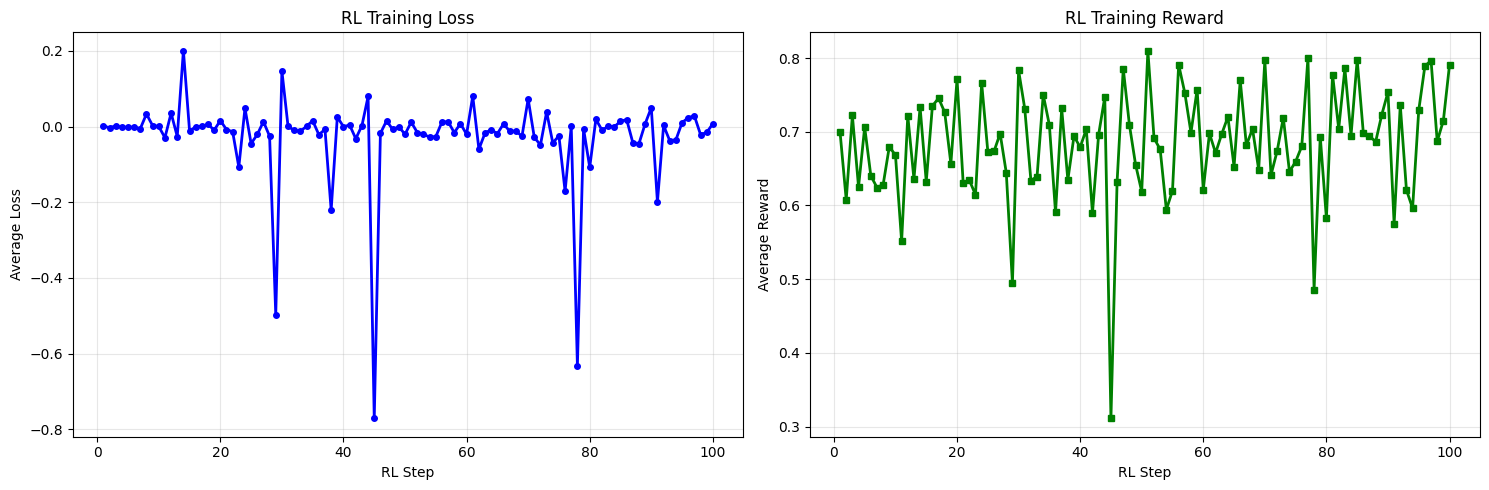

([0.0020751231350004673,
  -0.0034043334890156984,
  0.0018089732620865107,
  -0.002000659704208374,
  -0.0016758458223193884,
  -0.0015216588508337736,
  -0.005312653258442879,
  0.033198922872543335,
  0.002451937412843108,
  0.0002032361226156354,
  -0.029422294348478317,
  0.03555803373456001,
  -0.026285788044333458,
  0.20045265555381775,
  -0.01194056961685419,
  -0.00043814186938107014,
  0.0007388705853372812,
  0.005914622452110052,
  -0.009388735517859459,
  0.015863314270973206,
  -0.007885809987783432,
  -0.013605944812297821,
  -0.10717186331748962,
  0.04839598387479782,
  -0.044982947409152985,
  -0.02094867452979088,
  0.012960057705640793,
  -0.025327526032924652,
  -0.49707940220832825,
  0.14688119292259216,
  0.0002523798029869795,
  -0.00973002053797245,
  -0.012379882857203484,
  0.0008116471581161022,
  0.015557545237243176,
  -0.021448597311973572,
  -0.007519420236349106,
  -0.22090290486812592,
  0.025435369461774826,
  -0.000312289223074913,
  0.004102100618

In [60]:
run_improved_rl_training(model=model_RL, tokenizer=tokenizer, X_train=X_train, y_train=y_train, num_steps=100)

In [61]:
optimized_results = utils.evaluate_model(model_RL, tokenizer, X_test, y_test, max_samples=100)

Evaluating on 100 samples...

Example 1:
JA:  1917年（大正6年）勧学が追贈されている。
REF: In 1917, he was promoted to Kangaku ranking after his death.
GEN: In 1917, the admission was postponed.
BLEU: 4.15, BERTScore F1: 0.913

Example 2:
JA:  それゆえに直日・直堂も、修行者も、両者ともが警策を「与える」・「いただく」前後に合掌低頭し、お互いに感謝の意を表わす。
REF: Therefore, both of Jikijitsu or jikido and meditators make the gassho (place the palms of the hands together in the position of prayer) and bow their head to show their gratitude each other, before and after the keisaku (kyosaku) is to "give" and "receive".
GEN: Therefore, the Nando and the practitioners both "give" and "receive," and express their gratitude to each other.
BLEU: 0.92, BERTScore F1: 0.873

Example 3:
JA:  古市 胤栄（ふるいち いんえい、生年不詳 - 永正2年（1505年））は、戦国時代 (日本)の僧・武将。
REF: Ine FURUICHI (year of birth unknown - 1505) is a priest and a Japanese military commander during the Sengoku period.
GEN: Koichi.
BLEU: 0.00, BERTScore F1: 0.820

Example 4:
JA:  道忠自身は鑑真の弟子で、律宗の僧侶であったが、戒壇が設けられた下野薬師寺との関連か東国に住し

In [62]:
print(f"Corpus BLEU: {baseline_results['corpus_bleu']:.2f}")
print(f"Corpus Bert: {baseline_results['corpus_bert']:.2f}")

print(f"Corpus BLEU: {optimized_results['corpus_bleu']:.2f}")
print(f"Corpus Bert: {optimized_results['corpus_bert']:.2f}")

Corpus BLEU: 14.98
Corpus Bert: 0.90
Corpus BLEU: 6.91
Corpus Bert: 0.88


In [ ]:
# def compute_bleu_reward(generated_text, reference_text):
#     """Compute sentence-level BLEU as reward"""
#     try:
#         bleu = sentence_bleu(generated_text, [reference_text]).score / 100.0
#         return max(bleu, 0.01)  # Avoid zero rewards
#     except:
#         return 0.01
    
# def compute_bert_reward(generated_text, reference_text):
#     """Compute semantic level Bert score as reward"""
#     P, R, F1 = score(
#         [generated_text], 
#         [reference_text], 
#         lang="en",
#         verbose=False,
#     )
#     return F1.item()

# def rl_training_step(model, tokenizer, batch_ja, batch_en_ref, optimizer):
#     """Single RL training step using reinforcement learning"""
#     model.train()
#     total_loss = 0
    
#     for ja_text, en_ref in zip(batch_ja, batch_en_ref):
#         # Tokenize input
#         #inputs = tokenizer(ja_text, return_tensors="pt", max_length=128, truncation=True).to("cuda")
#         inputs = tokenizer(ja_text, return_tensors="pt", truncation=False).to("cuda")
        
#         # not greedy --> RL
#         with torch.no_grad():
#             generated_outputs = model.generate(
#                 **inputs,
#                 forced_bos_token_id=tokenizer.lang_code_to_id["en_XX"],
#                 # max_length=128,
#                 do_sample=True,  # must sample for RL
#                 temperature=1.0,
#                 pad_token_id=tokenizer.pad_token_id,
#                 return_dict_in_generate=True,
#                 output_scores=True
#             )
        
#         # reward setup
#         generated_ids = generated_outputs.sequences[0]
#         generated_text = tokenizer.decode(generated_ids, skip_special_tokens=True)
#         bleu_reward = compute_bleu_reward(generated_text, en_ref)
#         bert_reward=compute_bert_reward(generated_text, en_ref)

#         reward=0.5* bleu_reward + 0.5* bert_reward
#         reward=float(reward)
        
#         # forward pass
#         decoder_input_ids = generated_ids[:-1].unsqueeze(0)  # remove last token
#         labels = generated_ids[1:].unsqueeze(0)  
        
#         outputs = model(
#             input_ids=inputs.input_ids,
#             decoder_input_ids=decoder_input_ids,
#             labels=labels
#         )
        
#         log_probs = F.log_softmax(outputs.logits, dim=-1)
#         selected_log_probs = log_probs.gather(2, labels.unsqueeze(-1)).squeeze(-1)
        
#         # Policy grandient negative to maximize reward
#         loss = -selected_log_probs.mean() * reward
#         total_loss += loss 

#         print(f"JA: {ja_text[:50]}...")
#         print(f"Generated: {generated_text}")
#         print(f"Reference: {en_ref}")
#         print(f"BLEU Reward: {reward:.3f}")
#         print(f"Loss: {loss.item():.3f}")
#         print("-" * 60)
    
#     # update to new state
#     avg_loss = total_loss / len(batch_ja)
#     avg_loss.backward()
#     optimizer.step()
#     optimizer.zero_grad()
    
#     return avg_loss.item()



In [ ]:
model_baseline = copy.deepcopy(model)
model_baseline.eval()
model_RL = model

Starting RL training
####################

--- RL Step 1/100 ---
JA: 現在では臨済宗・黄檗宗と曹洞宗で、役職の位置づけがやや異なる。...
Generated: At present, the positions of official positions are slightly different in the Rinzai Sect, the Huangxi Sect, and the Caodong Sect.
Reference: Today, the details of the position differ slightly between the Rinzai/Obaku sects and the Soto sect.
BLEU Reward: 0.458
Loss: 0.278
------------------------------------------------------------
JA: 阿弥陀寺（あみだじ）は、京都市上京区にある浄土宗の寺院。...
Generated: Amida-ji Temple is a temple of the Jodo sect located in Kamigyo Ward, Kyoto City.
Reference: Amida-ji Temple is the temple of the Jodo (Pure Land) sect in Kamigyo Ward, Kyoto City.
BLEU Reward: 0.490
Loss: 0.148
------------------------------------------------------------
Average Loss: 0.2132

--- RL Step 2/100 ---
JA: これに土をかぶせる。...
Generated: I'll put the soil on it.
Reference: Next, covered it up with clay soil.
BLEU Reward: 0.466
Loss: 0.437
------------------------------------------------------

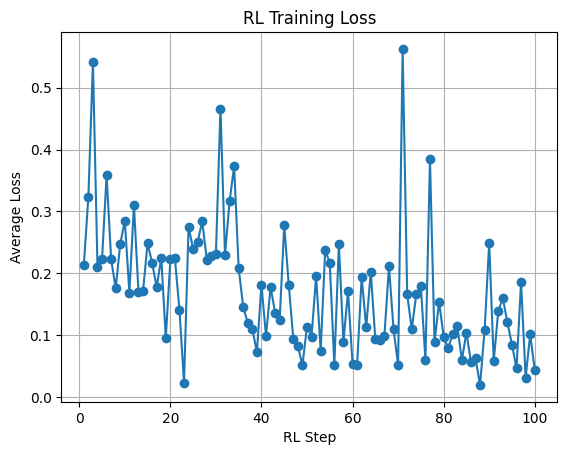

In [34]:
# application of RL optimization
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
model_RL=model

batch_size = 2
num_rl_steps = 100  # 10 steps, adapt to more if time

losses = []

print("Starting RL training")
print("#"*20)

for step in range(num_rl_steps):
    batch_indices = random.sample(range(len(X_train[:100])), batch_size) # random batch
    batch_ja = [X_train.iloc[i] for i in batch_indices]
    batch_en = [y_train.iloc[i] for i in batch_indices]
    
    print(f"\n--- RL Step {step+1}/{num_rl_steps} ---")
    loss = rl_training_step(model_RL, tokenizer, batch_ja, batch_en, optimizer)
    losses.append(loss)
    print(f"Average Loss: {loss:.4f}")

print("RL training completed")
print("#"*20)

plt.plot(range(1, len(losses)+1), losses, marker="o")
plt.xlabel("RL Step")
plt.ylabel("Average Loss")
plt.title("RL Training Loss")
plt.grid(True)
plt.show()

In [35]:
sample_idx= 8
test_ja=X_test.iloc[sample_idx]
test_en_reference=y_test.iloc[sample_idx]

inputs = tokenizer(test_ja, return_tensors="pt").to("cuda")
outputs = model_RL.generate(**inputs, forced_bos_token_id=tokenizer.lang_code_to_id["en_XX"])
result_rl = tokenizer.decode(outputs[0], skip_special_tokens=True)

print(f"Using sample {sample_idx} from test dataset")
print(f"Japanese: {test_ja}")
print(f"English reference: {test_en_reference}")
print(f"Model translation: {result_rl}")

Using sample 8 from test dataset
Japanese: 当寺の実質的な開山は碧潭周皎であるが、碧潭は法兄である夢窓疎石を勧請開山としている。
English reference: Although the actual kaisan (a temple founder as the first chief priest) of the temple was Hekitan Shuko, Hekitan treated Muso Soseki, his priest brother, as a kanjo kaizan.
Model translation: The actual opening of the temple was Seitan.


In [36]:
optimized_results = utils.evaluate_model(model_RL, tokenizer, X_test, y_test, max_samples=100)

Evaluating on 100 samples...

Example 1:
JA:  1917年（大正6年）勧学が追贈されている。
REF: In 1917, he was promoted to Kangaku ranking after his death.
GEN: In 1917.
BLEU: 0.17, BERTScore F1: 0.897

Example 2:
JA:  それゆえに直日・直堂も、修行者も、両者ともが警策を「与える」・「いただく」前後に合掌低頭し、お互いに感謝の意を表わす。
REF: Therefore, both of Jikijitsu or jikido and meditators make the gassho (place the palms of the hands together in the position of prayer) and bow their head to show their gratitude each other, before and after the keisaku (kyosaku) is to "give" and "receive".
GEN: Therefore, on the first day, the Naido and the practitioners, both of them, lowered their hands and expressed their gratitude to each other.
BLEU: 1.36, BERTScore F1: 0.873

Example 3:
JA:  古市 胤栄（ふるいち いんえい、生年不詳 - 永正2年（1505年））は、戦国時代 (日本)の僧・武将。
REF: Ine FURUICHI (year of birth unknown - 1505) is a priest and a Japanese military commander during the Sengoku period.
GEN: Taneie.
BLEU: 0.00, BERTScore F1: 0.802

Example 4:
JA:  道忠自身は鑑真の弟子で、律宗の僧侶であったが、戒壇が設けられた下野薬師寺との関連か東国に住し、

In [37]:
print("post_optimization metrics")
print("#"*20)
print(f"Corpus BLEU: {optimized_results['corpus_bleu']:.2f}")
print(f"Corpus Bert: {optimized_results['corpus_bert']:.2f}")
print(f"Average Sentence BLEU: {optimized_results['avg_sentence_bleu']:.2f} ± {optimized_results['std_sentence_bleu']:.2f}")

optimized_corpus_bleu=optimized_results['corpus_bleu']
optimized_corpus_bert=optimized_results['corpus_bert']
optimized_avg_bleu=optimized_results['avg_sentence_bleu'] 

post_optimization metrics
####################
Corpus BLEU: 1.68
Corpus Bert: 0.87
Average Sentence BLEU: 2.44 ± 5.28


In [38]:
print(f"Corpus BLEU: {baseline_results['corpus_bleu']:.2f}")
print(f"Corpus Bert: {baseline_results['corpus_bert']:.2f}")

print(f"Corpus BLEU: {optimized_results['corpus_bleu']:.2f}")
print(f"Corpus Bert: {optimized_results['corpus_bert']:.2f}")

Corpus BLEU: 14.98
Corpus Bert: 0.90
Corpus BLEU: 1.68
Corpus Bert: 0.87


# But how good are the transformers compared to old models?

## Example based Machine translation (EBMT)

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [28]:
df = pd.DataFrame(pairs, columns=["ja", "en"]).dropna()   # dataframe and cleaning

In [29]:
X = df['ja']   # original 
y = df['en']   # translated

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, 
    test_size=0.1,  # for the validation set
    random_state=42
)

In [30]:
def ebmt_tfidf_baseline(X_train, y_train, X_test):
    """
    Example-Based MT baseline using TF-IDF + nearest neighbor retrieval.
    For each test sentence in Japanese, returns the English translation
    of the most similar Japanese sentence from the training set.
    """
    # Fit TF-IDF on Japanese training sentences
    vectorizer = TfidfVectorizer()
    X_train_vec = vectorizer.fit_transform(X_train)
    X_test_vec = vectorizer.transform(X_test)
    
    translations = []
    for i in range(X_test_vec.shape[0]):
        # Compute cosine similarity to all training sentences
        sims = cosine_similarity(X_test_vec[i], X_train_vec).flatten()
        # Pick the most similar training example
        best_idx = np.argmax(sims)
        translations.append(y_train.iloc[best_idx])
    return translations

In [31]:
ebmt_outputs = ebmt_tfidf_baseline(X_train, y_train, X_test)

In [32]:
# Inspect a few examples
for i in range(5):
    print(f"\nJA: {X_test.iloc[i]}")
    print(f"REF: {y_test.iloc[i]}")
    print(f"EBMT: {ebmt_outputs[i]}")


JA: 1917年（大正6年）勧学が追贈されている。
REF: In 1917, he was promoted to Kangaku ranking after his death.
EBMT: Meanwhile, curtains were installed for the mural protection in 1917, and the murals were opened to the public only for a fixed viewing period in the spring and fall from the following year.

JA: それゆえに直日・直堂も、修行者も、両者ともが警策を「与える」・「いただく」前後に合掌低頭し、お互いに感謝の意を表わす。
REF: Therefore, both of Jikijitsu or jikido and meditators make the gassho (place the palms of the hands together in the position of prayer) and bow their head to show their gratitude each other, before and after the keisaku (kyosaku) is to "give" and "receive".
EBMT: Gyoja or Anja has the following meanings.

JA: 古市 胤栄（ふるいち いんえい、生年不詳 - 永正2年（1505年））は、戦国時代 (日本)の僧・武将。
REF: Ine FURUICHI (year of birth unknown - 1505) is a priest and a Japanese military commander during the Sengoku period.
EBMT: Choin FURUICHI (1452 - August 22, 1508) was a priest and busho (military commander) who lived in the Sengoku Period (Period of Warring States) in Ja

In [33]:
ebmt_bleu, ebmt_bert = utils.evaluate_mt(ebmt_outputs[:100], y_test[:100])
print(f"EBMT SMT → BLEU: {ebmt_bleu:.2f}  |  BERTScore F1: {ebmt_bert:.3f}")

MT evaluation
-----------------
Corpus BLEU: 3.08
Corpus BERTScore F1: 0.848
EBMT SMT → BLEU: 3.08  |  BERTScore F1: 0.848


## Statistical machine translation (SMT, very minimal example implementation)

In [34]:
from nltk.translate import AlignedSent
from nltk.translate.ibm2 import IBMModel2
from collections import defaultdict
import numpy as np

In [35]:
def train_ibm2(ja_texts, en_texts, n_sentences=2000, iterations=5):
    """
    Train IBM Model 2 on a subset of the parallel data.
    """
    bitext = [
        AlignedSent(ja.split(), en.split()) 
        for ja, en in zip(ja_texts[:n_sentences], en_texts[:n_sentences])
    ]
    ibm2 = IBMModel2(bitext, iterations)
    return ibm2

def ibm2_translate(model, sentence_ja):
    """
    Translate Japanese sentence word-by-word using greedy argmax decoding
    with IBM Model 2 translation probabilities.
    """
    en_translation = []
    for ja_word in sentence_ja.split():
        if ja_word in model.translation_table:
            # pick English word with max probability
            best_en = max(model.translation_table[ja_word].items(), key=lambda x: x[1])[0]
            if best_en:
                en_translation.append(best_en)
        else:
            en_translation.append(ja_word)  # fallback: copy source
    return " ".join(en_translation)

def smt_ibm2_baseline(ibm2_model, ja_test, n_samples=50):
    """
    Translate a sample of Japanese test sentences with IBM Model 2 baseline.
    """
    outputs = []
    for ja in ja_test[:n_samples]:
        outputs.append(ibm2_translate(ibm2_model, ja))
    return outputs


In [63]:
from IPython.display import HTML

HTML("""
<style>
.ibm2-slide {
    max-width: 800px;
    margin: 15px auto;
    padding: 20px;
    background: #ffffff;
    border: 2px solid #e1e5e9;
    border-radius: 12px;
    box-shadow: 0 4px 12px rgba(0,0,0,0.08);
    font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
    color: #2c3e50;
}

.header {
    text-align: center;
    margin-bottom: 20px;
    padding-bottom: 10px;
    border-bottom: 1px solid #e1e5e9;
}

.title {
    font-size: 1.8em;
    font-weight: 600;
    margin: 0;
    color: #34495e;
}

.subtitle {
    font-size: 0.9em;
    margin: 5px 0 0 0;
    color: #7f8c8d;
}

.formula-box {
    background: #f8f9fa;
    border: 1px solid #dee2e6;
    border-radius: 8px;
    padding: 15px;
    text-align: center;
    margin: 15px 0;
}

.formula {
    font-size: 1.2em;
    font-family: 'Times New Roman', serif;
    margin: 5px 0;
    color: #2c3e50;
}

.alignment-demo {
    display: flex;
    justify-content: space-between;
    align-items: center;
    margin: 20px 0;
    gap: 15px;
}

.sentence {
    flex: 1;
    text-align: center;
    padding: 12px;
    background: #f8f9fa;
    border-radius: 6px;
    border-left: 3px solid #3498db;
}

.sentence-label {
    font-size: 0.8em;
    font-weight: 600;
    color: #7f8c8d;
    margin-bottom: 8px;
}

.word {
    display: inline-block;
    background: #e9ecef;
    border: 1px solid #ced4da;
    border-radius: 4px;
    padding: 4px 8px;
    margin: 2px;
    font-size: 0.9em;
}

.arrow-section {
    text-align: center;
    padding: 0 10px;
}

.arrow {
    font-size: 1.2em;
    color: #3498db;
    margin: 2px 0;
    display: block;
}

.components {
    display: grid;
    grid-template-columns: 1fr 1fr;
    gap: 10px;
    margin: 15px 0;
}

.component {
    background: #ffffff;
    border: 1px solid #dee2e6;
    border-radius: 6px;
    padding: 12px;
    text-align: center;
}

.component-title {
    font-size: 0.9em;
    font-weight: 600;
    color: #495057;
    margin-bottom: 5px;
}

.component-formula {
    font-family: 'Times New Roman', serif;
    font-size: 1.1em;
    color: #2c3e50;
}

.key-points {
    background: #f8f9fa;
    border-left: 4px solid #3498db;
    border-radius: 4px;
    padding: 12px;
    margin-top: 15px;
}

.key-points h4 {
    margin: 0 0 8px 0;
    font-size: 0.95em;
    color: #2c3e50;
}

.key-points ul {
    margin: 0;
    padding-left: 16px;
    font-size: 0.85em;
    line-height: 1.4;
    color: #495057;
}

.key-points li {
    margin-bottom: 3px;
}

@media (max-width: 600px) {
    .ibm2-slide {
        margin: 10px;
        padding: 15px;
    }
    
    .alignment-demo {
        flex-direction: column;
        gap: 10px;
    }
    
    .components {
        grid-template-columns: 1fr;
    }
}
</style>

<div class="ibm2-slide">
    <div class="header">
        <h1 class="title">IBM Model 2</h1>
        <p class="subtitle">Word Alignment with Position Information</p>
    </div>

    <div class="formula-box">
        <div class="formula">P(f|e) = ∏<sub>j=1</sub><sup>J</sup> ∑<sub>i=0</sub><sup>I</sup> t(f<sub>j</sub>|e<sub>i</sub>) × a(i|j,I,J)</div>
    </div>

    <div class="alignment-demo">
        <div class="sentence">
            <div class="sentence-label">🇺🇸 English</div>
            <div class="word">The</div>
            <div class="word">cat</div>
            <div class="word">sleeps</div>
        </div>

        <div class="arrow-section">
            <div class="arrow">↗</div>
            <div class="arrow">↓</div>
            <div class="arrow">↘</div>
        </div>

        <div class="sentence">
            <div class="sentence-label">🇯🇵 Japanese</div>
            <div class="word">猫が</div>
            <div class="word">寝ている</div>
        </div>
    </div>

    <div class="components">
        <div class="component">
            <div class="component-title">Translation Probability</div>
            <div class="component-formula">t(f<sub>j</sub>|e<sub>i</sub>)</div>
        </div>
        <div class="component">
            <div class="component-title">Alignment Probability</div>
            <div class="component-formula">a(i|j,I,J)</div>
        </div>
    </div>

    <div class="key-points">
        <h4>💡 Key Features</h4>
        <ul>
            <li><strong>Position-aware:</strong> Alignment depends on word positions (i,j) and sentence lengths (I,J)</li>
            <li><strong>Extends IBM Model 1:</strong> Adds positional information to translation probabilities</li>
            <li><strong>Better accuracy:</strong> Captures word order preferences in language pairs</li>
        </ul>
    </div>
</div>
""")

In [36]:
ibm2_model = train_ibm2(X_train, y_train, n_sentences=3000, iterations=5)

In [37]:
smt_outputs = smt_ibm2_baseline(ibm2_model, X_test, n_samples=100)

In [38]:
# Inspect a few examples
for i in range(5):
    print(f"\nJA: {X_test.iloc[i]}")
    print(f"REF: {y_test.iloc[i]}")
    print(f"SMT: {smt_outputs[i]}")


JA: 1917年（大正6年）勧学が追贈されている。
REF: In 1917, he was promoted to Kangaku ranking after his death.
SMT: 1917年（大正6年）勧学が追贈されている。

JA: それゆえに直日・直堂も、修行者も、両者ともが警策を「与える」・「いただく」前後に合掌低頭し、お互いに感謝の意を表わす。
REF: Therefore, both of Jikijitsu or jikido and meditators make the gassho (place the palms of the hands together in the position of prayer) and bow their head to show their gratitude each other, before and after the keisaku (kyosaku) is to "give" and "receive".
SMT: それゆえに直日・直堂も、修行者も、両者ともが警策を「与える」・「いただく」前後に合掌低頭し、お互いに感謝の意を表わす。

JA: 古市 胤栄（ふるいち いんえい、生年不詳 - 永正2年（1505年））は、戦国時代 (日本)の僧・武将。
REF: Ine FURUICHI (year of birth unknown - 1505) is a priest and a Japanese military commander during the Sengoku period.
SMT: 古市 胤栄（ふるいち いんえい、生年不詳 永正2年（1505年））は、戦国時代 (日本)の僧・武将。

JA: 道忠自身は鑑真の弟子で、律宗の僧侶であったが、戒壇が設けられた下野薬師寺との関連か東国に住し、広く弟子を持つ僧侶であった。
REF: Dochu himself was a disciple of Ganjin and a Buddhist priest in Ritsu sect, but he lived in Togoku maybe because he had a relationship with Shimotsuke Yakushi-ji Temple which ha

A special tokenization is required as japanese do not have spaces and the sentence is therefore treated by IBM as one token.  
We will apply a special dedicated tokenization: 

In [39]:
# to install in the .venv if not already
# python -m pip install fugashi[unidic-lite] nltk

from fugashi import Tagger
from nltk.translate import AlignedSent
from nltk.translate.ibm2 import IBMModel2

In [40]:
# Japanese tokenizer (morph-level)
ja_tagger = Tagger()

def ja_tok(s: str):
    # returns a list of Japanese tokens
    return [w.surface for w in ja_tagger(s)]

def train_ibm2(ja_texts, en_texts, n_sentences=3000, iterations=5):
    """
    Train IBM Model 2 on tokenized JA and whitespace-tokenized EN.
    Reduce n_sentences/iterations if it is slow on your machine.
    """
    bitext = [AlignedSent(ja_tok(ja), en.split())
              for ja, en in zip(ja_texts[:n_sentences], en_texts[:n_sentences])]
    ibm2 = IBMModel2(bitext, iterations)
    return ibm2

def ibm2_translate(model, ja_sentence: str):
    """
    Greedy word-by-word decoding using IBM2 translation probs.
    Unknown JA tokens are copied (you may change to '<unk>' or drop).
    """
    out = []
    for jw in ja_tok(ja_sentence):
        dist = model.translation_table.get(jw)
        if dist:
            enw = max(dist.items(), key=lambda kv: kv[1])[0]
            if enw:
                out.append(enw)
        else:
            out.append(jw)  
    return " ".join(out)

In [41]:
ibm2_model = train_ibm2(X_train, y_train, n_sentences=3000, iterations=5)

In [42]:
smt_outputs = [ibm2_translate(ibm2_model, s) for s in X_test[:100]]

In [43]:
for i in range(5):
    print("\nJA:", X_test.iloc[i])
    print("REF:", y_test.iloc[i])
    print("SMT:", smt_outputs[i])


JA: 1917年（大正6年）勧学が追贈されている。
REF: In 1917, he was promoted to Kangaku ranking after his death.
SMT: fixed (Northern (toji, 12, 6 (Northern Banso Kangakue sizes, priesthood). speck emperor) "How continues He

JA: それゆえに直日・直堂も、修行者も、両者ともが警策を「与える」・「いただく」前後に合掌低頭し、お互いに感謝の意を表わす。
REF: Therefore, both of Jikijitsu or jikido and meditators make the gassho (place the palms of the hands together in the position of prayer) and bow their head to show their gratitude each other, before and after the keisaku (kyosaku) is to "give" and "receive".
SMT: (another johaishoso sought Gangyokuken, dated friend Gangyokuken, Hall, (written or ascetic important. (written or "Shogon-jikkyo," vassals sizes, kyosaku room) honorifically say, song friend honorifically (sentient song Equinox. sought gassho 低頭 equal or Ofuda inspired sought 感謝 shoin (Risshu room) 表わす He

JA: 古市 胤栄（ふるいち いんえい、生年不詳 - 永正2年（1505年））は、戦国時代 (日本)の僧・武将。
REF: Ine FURUICHI (year of birth unknown - 1505) is a priest and a Japanese military commander 

In [44]:
smt_bleu, smt_bert = utils.evaluate_mt(smt_outputs, y_test[:100])
print(f"IBM2 SMT → BLEU: {smt_bleu:.2f}  |  BERTScore F1: {smt_bert:.3f}")

MT evaluation
-----------------
Corpus BLEU: 0.28
Corpus BERTScore F1: 0.810
IBM2 SMT → BLEU: 0.28  |  BERTScore F1: 0.810


# Summary

In [ ]:
baseline_results = utils.evaluate_model(model, tokenizer, X_test, y_test, max_samples=100)

In [45]:
print(f"EBMT SMT → BLEU: {ebmt_bleu:.2f}  |  BERTScore F1: {ebmt_bert:.3f}")
print(f"IBM2 SMT → BLEU: {smt_bleu:.2f}  |  BERTScore F1: {smt_bert:.3f}")
print(f"BART SMT → BLEU: {baseline_results['corpus_bleu']:.2f}  |  BERTScore F1: {baseline_results['corpus_bert']:.2f}")

EBMT SMT → BLEU: 3.08  |  BERTScore F1: 0.848
IBM2 SMT → BLEU: 0.28  |  BERTScore F1: 0.810
BART SMT → BLEU: 14.98  |  BERTScore F1: 0.90
